<a href="https://colab.research.google.com/github/dtabuena/Ephys_DataSets/blob/main/Analyze_BMX_HEK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
'Get Standard Modules'

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import os
from scipy.signal import butter,filtfilt
from tqdm import tqdm
import warnings
from IPython.display import clear_output
from datetime import datetime
import sys
import warnings
import shutil
from google.colab import files
warnings.filterwarnings('ignore')
np.set_printoptions(threshold=sys.maxsize)
clear_output(wait=False)



!pip install openpyxl
!pip install XlsxWriter


'''Get Repositories'''
try: shutil.rmtree('/content/EphysLib')
except: None

"run dtabuena's ephys notebooks"
!git clone https://github.com/dtabuena/EphysLib
to_import = [
            'ABF_Quality_Control.ipynb',
            'Basic_Ephys.ipynb',
            'Simple_ABF_tools.ipynb',
            'fun_math.ipynb',
            'importing_abfs_from_dropbox.ipynb',
            'QC_recoding_dataframe.ipynb',
            'Analyzers/input_resistance_analyzer.ipynb',
            'Analyzers/gain_analyzer.ipynb',
            'Analyzers/latencey_analyzer.ipynb',
            'Analyzers/IV_analyzer.ipynb',
            'Analyzers/Vm_analyzer.ipynb',
            'Analyzers/membrane_analyzer.ipynb',
            'Analyzers/rheobase_analyzer.ipynb',

            'Ephys_wrapper.ipynb',
            ]
for i in to_import:
    f = '/content/EphysLib/' + i
    %run $f




Cloning into 'EphysLib'...
remote: Enumerating objects: 1141, done.
remote: Counting objects: 100% (518/518), done.
remote: Compressing objects: 100% (247/247), done.
remote: Total 1141 (delta 377), reused 359 (delta 271), pack-reused 623
Receiving objects: 100% (1141/1141), 17.41 MiB | 16.82 MiB/s, done.
Resolving deltas: 100% (754/754), done.


In [ ]:
##### Setup Protocol List
VC_prot = ['VC - MemTest-10ms-160ms',
           'VC - Multi IV - 150ms',]
IC_prot = ['IC - Gain - D20pA',
           'IC - Gain - D50pA',
           'IC - Rheobase',
           'IC - R input',
           'IC - Latentcy 800pA-1s'
           'VC - 3min GapFree',
           'I0 - 3min GapFree']

In [ ]:
file_loc

'my_ephys_data_Today'

In [2]:
dataset = {'data_name': 'BMX',
           'data_source': "https://www.dropbox.com/scl/fo/2ps1mdb88490cgol95l3u/h?rlkey=trp33s4fhrl4pyg4h4k0jecwh&dl=1",
           'file_naming_scheme': ['Rec_date','GenoType','Cell_num','Cell_Type'],
           }
##2023x12x13_SLICK_c001_HEK_0001
data_name = dataset['data_name']
data_source = dataset['data_source']
file_naming_scheme = dataset['file_naming_scheme']

''' Gather and Catalog Source Data'''
file_loc = get_drobox_folder_url(data_source, 'my_ephys_data_' + data_name)
clear_output(wait=False)
abf_recordings_df, protocol_set = catalogue_recs(file_loc,file_naming_scheme)
print(protocol_set)

['K_total_Run', 'K_total', 'VC - MemTest-10ms-160ms']


In [6]:
abf = pyabf.ABF('/content/my_ephys_data_BMX/2023x12x13/2023x12x13_SLICK_c001_HEK_0001.abf')
def analyze_k_current(abf,start_ms,stop_ms,metric_function=np.mean):




In [3]:

display(abf_recordings_df.columns)

Index(['Recording_name', 'cell_id', 'Rec_date', 'GenoType', 'Cell_num',
       'Cell_Type', 'protocol', 'abf_timestamp', 'channelList'],
      dtype='object')

Archive:  /content/my_ephys_data_Today.zip
mapname:  conversion of  failed
replace /content/my_ephys_data_Today/2023x10x26_WT_Sag_P586_s001_c001_CA3_0000.abf? [y]es, [n]o, [A]ll, [N]one, [r]ename:  extracting: /content/my_ephys_data_Today/2023x10x26_WT_Sag_P586_s001_c001_CA3_0000.abf  
 extracting: /content/my_ephys_data_Today/2023x10x26_WT_Sag_P586_s001_c001_CA3_0001.abf  
 extracting: /content/my_ephys_data_Today/2023x10x26_WT_Sag_P586_s001_c001_CA3_0002.abf  
 extracting: /content/my_ephys_data_Today/2023x10x26_WT_Sag_P586_s001_c001_CA3_0003.abf  
 extracting: /content/my_ephys_data_Today/2023x10x26_WT_Sag_P586_s001_c001_CA3_0004.abf  
 extracting: /content/my_ephys_data_Today/2023x10x26_WT_Sag_P586_s001_c001_CA3_0005.abf  
 extracting: /content/my_ephys_data_Today/2023x10x26_WT_Sag_P586_s001_c001_CA3_0006.abf  
 extracting: /content/my_ephys_data_Today/2023x10x26_WT_Sag_P586_s001_c001_CA3_0007.abf  
 extracting: /content/my_ephys_data_Today/2023x10x26_WT_Sag_P586_s001_c001_CA3_0008

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{'spike_thresh': 20, 'high_dv_thresh': 50, 'low_dv_thresh': -30, 'window_ms': 2}


  0%|          | 0/9 [00:00<?, ?it/s]

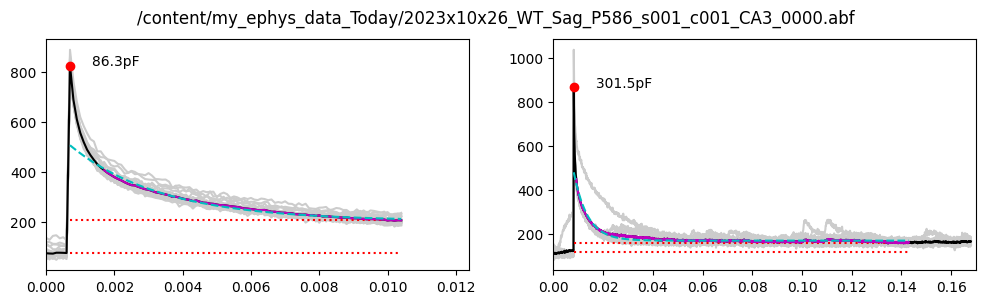

 11%|█         | 1/9 [00:01<00:08,  1.09s/it]

<Figure size 640x480 with 0 Axes>

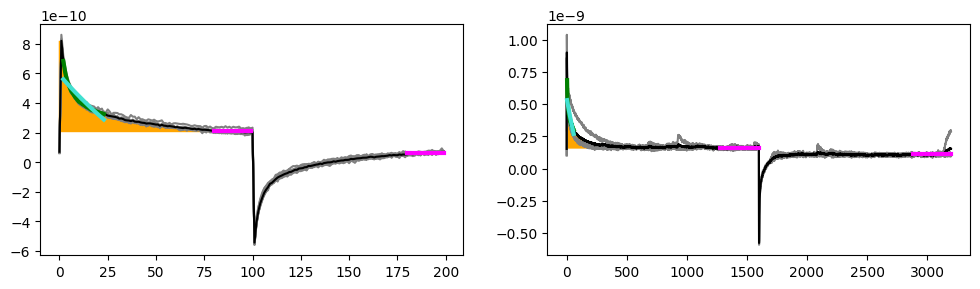

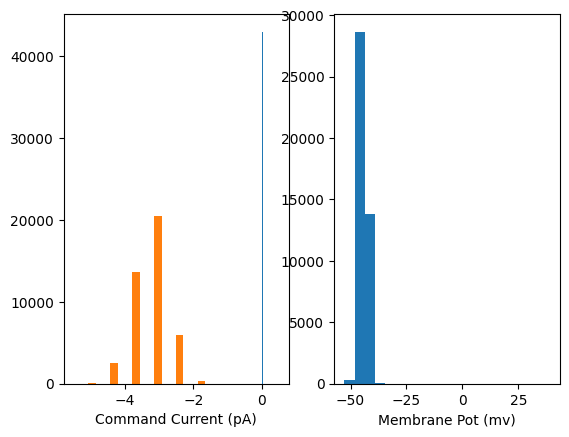

 22%|██▏       | 2/9 [00:01<00:06,  1.13it/s]

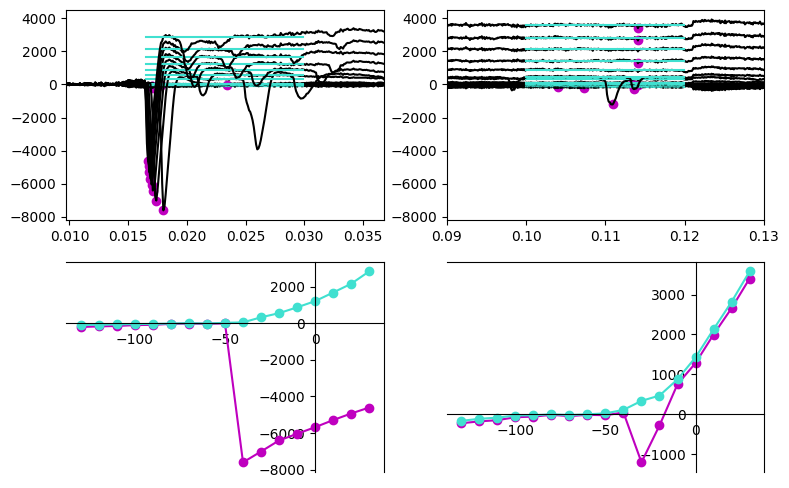

 33%|███▎      | 3/9 [00:03<00:07,  1.25s/it]

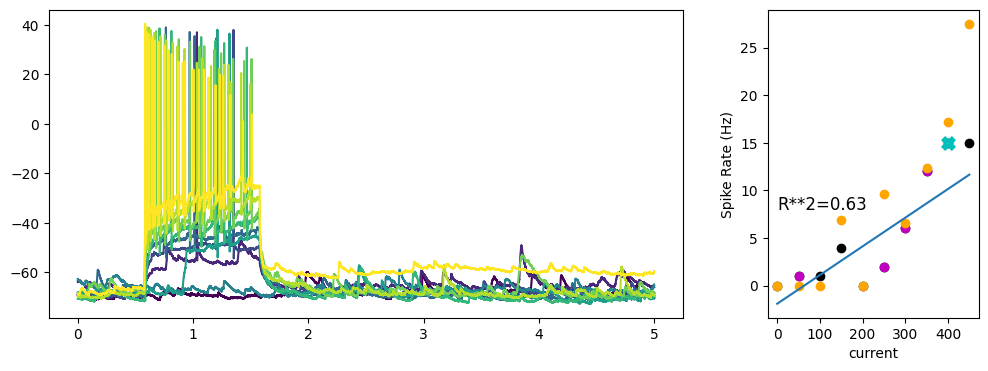

 44%|████▍     | 4/9 [00:07<00:11,  2.37s/it]

ap_thresh_us -47.49864894428446


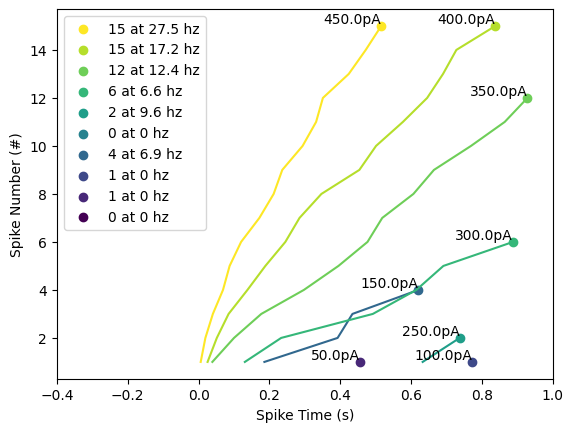

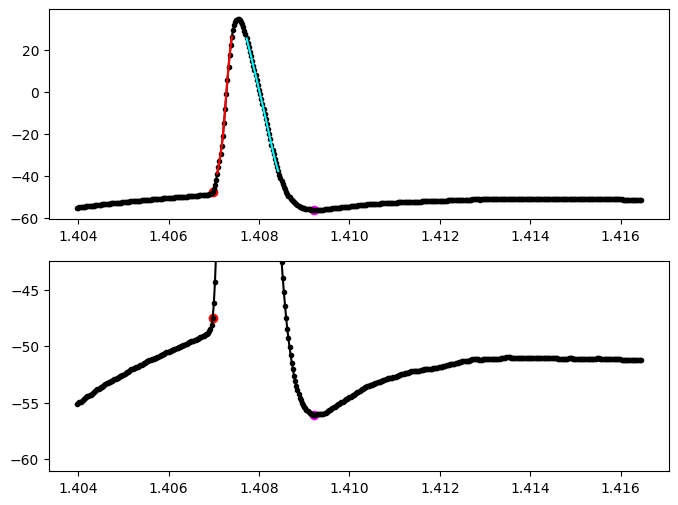

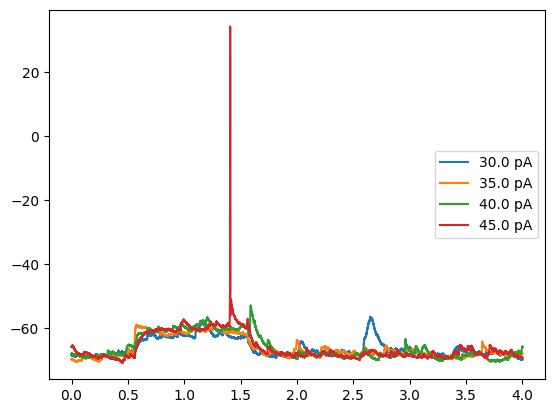

 56%|█████▌    | 5/9 [00:12<00:12,  3.21s/it]

<Figure size 640x480 with 0 Axes>

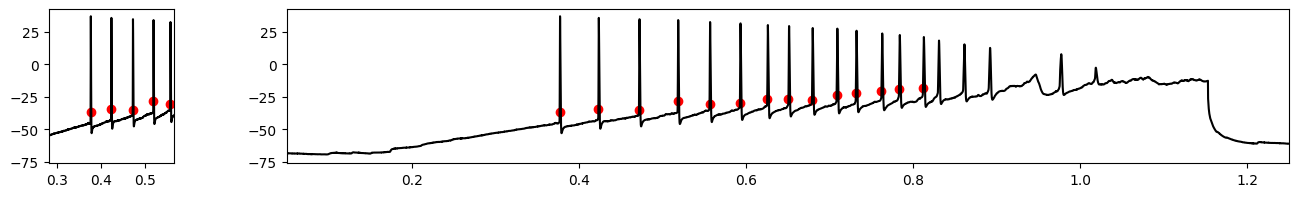

 67%|██████▋   | 6/9 [00:12<00:06,  2.32s/it]

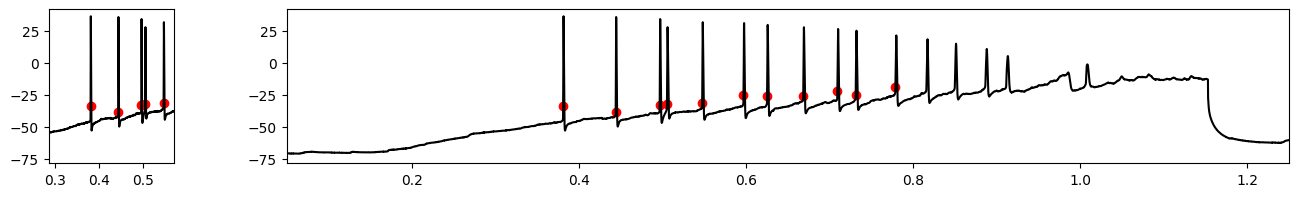

 89%|████████▉ | 8/9 [00:14<00:01,  1.51s/it]

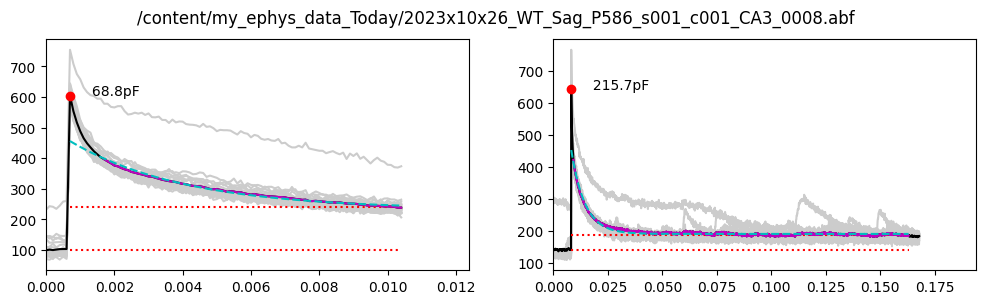

100%|██████████| 9/9 [00:15<00:00,  1.74s/it]

problem_recs
  adding: content/Saved_Figs/ (stored 0%)
  adding: content/Saved_Figs/Firing_Gain/ (stored 0%)
  adding: content/Saved_Figs/Firing_Gain/Firing_Gain_2023x10x26_WT_Sag_P586_s001_c001_CA3_0003.png (deflated 4%)
  adding: content/Saved_Figs/Firing_Gain/Adaption_2023x10x26_WT_Sag_P586_s001_c001_CA3_0003.png (deflated 6%)
  adding: content/Saved_Figs/Spike_latency/ (stored 0%)
  adding: content/Saved_Figs/Spike_latency/Spike_latency_2023x10x26_WT_Sag_P586_s001_c001_CA3_0006.png (deflated 10%)
  adding: content/Saved_Figs/Spike_latency/Spike_latency_2023x10x26_WT_Sag_P586_s001_c001_CA3_0005.png (deflated 11%)
  adding: content/Saved_Figs/Input_Resitance/ (stored 0%)
  adding: content/Saved_Figs/Input_Resitance/Input_Resitance_2023x10x26_WT_Sag_P586_s001_c001_CA3_0007.png (deflated 25%)
  adding: content/Saved_Figs/AP_Params/ (stored 0%)
  adding: content/Saved_Figs/AP_Params/AP_Params_2023x10x26_WT_Sag_P586_s001_c001_CA3_0004.png (deflated 35%)
  adding: content/Saved_Figs/IV_Cu

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

_0007.abf
_0004.abf
_0005.abf
_0003.abf
_0002.abf
_0000.abf
_0001.abf
_0008.abf
_0006.abf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

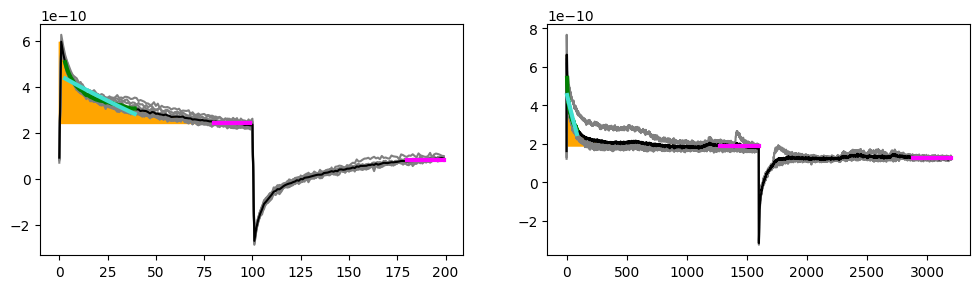

In [ ]:
#
Fast_results = ephys_wrapper(dataset,VC_prot,IC_prot,strat_cols=[ 'Cell_Type'])

In [ ]:
# strat_abfs_by_prot( 'reorg','/content/my_ephys_data_'+dataset['data_name'], f"/content/{dataset['data_name']}_Recording_LookUp.csv" )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# single_val_strat_groups = ['ap_amplitutude',
#                             'Rmp_mV',
#                             'Ra_160.0',
#                             'Rm_160.0',
#                             'Cm_pc_10.0',
#                             'Cmq_160.0',
#                             'Ra_160.0',
#                             'Rm_160.0',
#                             'Gain_(HzpA)',
#                             'max_adapt%',
#                             'adapt_thresh_90',
#                             'Rheobase',
#                             'AP_thresh_US',
#                             'fast_after_hyperpol',
#                             'Spike_latency_(ms)',
#                             'Input_Resistance_MO',
#                             ]


# manual_exclusions = [''] # Dramatic shift in seal at unknown time during recording.
# exclusion_overide = [''] # Vm dramatically improved prior to gain recording


# strat_df_dict = Fast_results['strat_df_dict'].copy()
# file_naming_scheme = ['Rec_date', 'GenoType', 'Sex', 'Age', 'Slice_Num', 'Cell_num', 'Cell_Type']
# filtered_dict, fail_dict = final_qc(strat_df_dict,file_naming_scheme,qc_Rmp=-45,qc_AP_amp=40,qc_RR=.35,qc_Ra=65,manual_exclusions=manual_exclusions,exclusion_overide=exclusion_overide)
# alt_strat_dict = restratify_results(filtered_dict,file_naming_scheme,single_val_strat_groups)
# resp_curve_list = ['IV_Early_(V_stim)','IV_Early_(I_peak)','IV_Steady_State_(I_mean)','Stim_Levels_(pA)','Spike_Counts']
# response_curve_data = stratify_response_curve(filtered_dict,resp_curve_list,strat_list=[''])
# alt_strat_dict.update(response_curve_data)

# write_strat_dfs(alt_strat_dict, dataset['data_name']+'_results_stratified_alternate')

2022x11x30_E4KI_F_P564_s001_c001_DG Fail - AP = 29.568223626286642 mV
2022x11x30_E4KI_F_P564_s001_c003_DG Fail - Ra = 70.35022856703917
2022x11x30_E4KI_F_P564_s001_c004_DG Fail - AP = 37.24684471596113 mV
2022x11x30_E4KI_F_P564_s001_c005_DG Fail - Ra = 91.92099380069118
2022x11x30_E4KI_F_P564_s002_c001_DG Fail - Ra = 70.55274856296731
2022x11x30_E4KI_F_P564_s002_c002_DG Fail - Ra = 82.25370865551344
2022x11x30_E4KI_F_P564_s002_c004_DG Fail - AP = 31.486596630028743 mV
2022x12x01_E4KI_F_P564_s001_c006_DG Fail - AP = 36.57205822762453 mV
2022x12x01_E4KI_F_P564_s001_c007_DG Fail - Ra = 70.94062576178689
2022x12x01_E4KI_F_P564_s002_c012_DG Fail - AP = 33.80026328591212 mV
2022x12x01_E4KI_F_P564_s002_c013_DG Fail - Ra = 65.37365759609162
2022x12x02_E3KI_F_P595_s001_c006_DG Fail - Ra = 75.18470938315177
2022x12x02_E3KI_F_P595_s002_c011_DG Fail - Ra = 84.46397576506654
2022x12x02_E3KI_F_P595_s002_c014_DG Fail - AP = 33.98094187745181 mV
ap_amplitutude
Rmp_mV
Ra_160.0
Rm_160.0
Cm_pc_10.0
Cmq_1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

5sd: 7.306934441628112
(53, 250)


(24.25, 28.25)

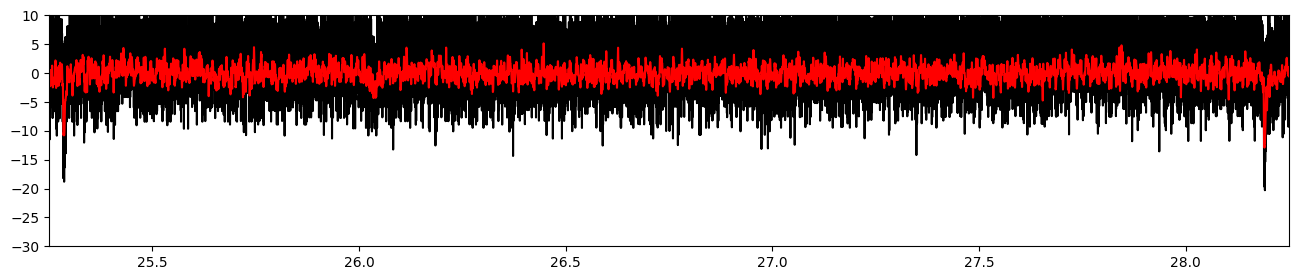

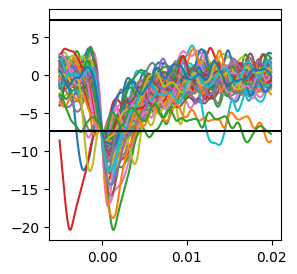

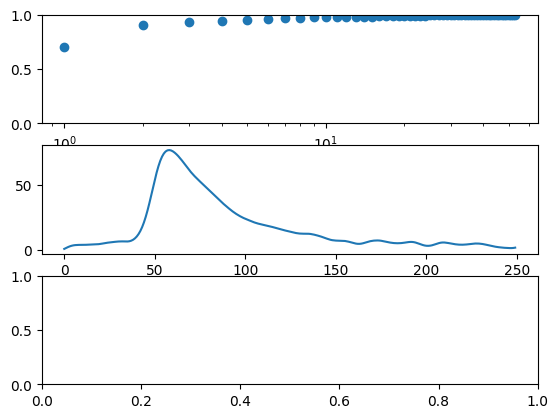

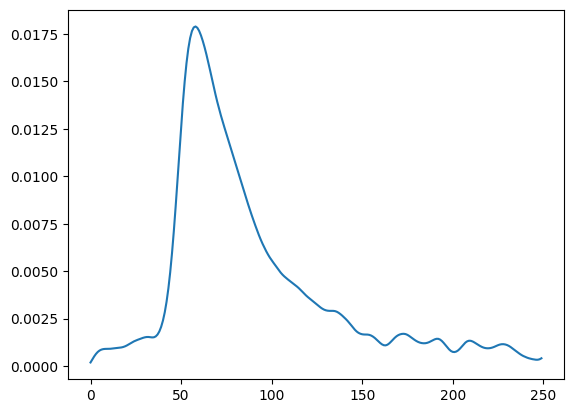

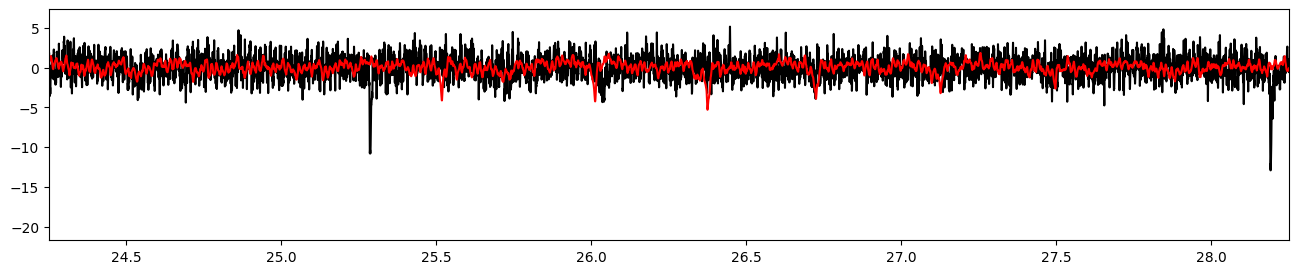

In [ ]:
import scipy as sc




def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = np.min([1-1/fs,highcut / nyq])
    b, a = sc.signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=2):

    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    data = sc.signal.filtfilt(b, a, data)

    b_notch,a_notch = sc.signal.iirnotch(50, 20, fs=fs)
    data = sc.signal.filtfilt(a_notch, a_notch, data)
    data = data-np.mean(data)
    return data

def filter_for_PSCs(abf, lowcut, highcut,):
    time = abf.sweepX
    response = abf.sweepY
    holding = abf.sweepC
    fs=abf.sampleRate
    response_f1 = butter_bandpass_filter(response, lowcut, highcut, fs  )
    response_f2 = butter_bandpass_filter(response, .01, 5000, fs  )

    fig,ax = plt.subplots(1,figsize=[16,3])
    ax.plot(time,response_f2,'k')
    ax.plot(time,response_f1,'r')
    x0 = np.random.choice(time,1)
    x0 = 25.25
    dur = 3
    xlims = x0 +np.array([0,dur])
    ax.set_xlim(xlims)
    ax.set_ylim([-30,10])

    return response_f1

def find_events(response_f1,fs, sd_thresh = 5,cool_down_time=0,to_plot= True):
    sd = np.std(response_f1)
    print(str(sd_thresh)+'sd:',sd*sd_thresh)
    cool_down_idx = cool_down_time*fs
    is_event = abs(response_f1)>sd*sd_thresh
    event_start = np.diff(is_event,prepend=0)>0
    starts = np.where(event_start)[0]

    x0t = -.005
    x1t = 0.02
    x0n = x0t*fs
    x1n = x1t*fs

    fig,ax = plt.subplots(1,figsize=[3,3])
    time_wind = np.arange(x0t,x1t,1/fs)
    stack = []
    for e in starts:
        indx_wind = e + np.arange(x0n,x1n,dtype=int)
        try:
            resp_wind = response_f1[indx_wind]
            ax.plot(time_wind,resp_wind)
            stack.append(resp_wind)
        except: None

    ax.axhline(sd*sd_thresh,color='k')
    ax.axhline(-sd*sd_thresh,color='k')
    stack_np = np.stack(stack,axis=0)
    print(stack_np.shape)

    return stack_np

to_plot= True
abf=abf_or_name('my_ephys_data_Today/2023x04x12_E4KI_F_P236_s001_c001_DG_0007.abf')



response_f1 = filter_for_PSCs(abf, lowcut = 1, highcut = 500)
stack_np = find_events(response_f1,fs, sd_thresh = 5,cool_down_time = 0.005 , to_plot= True)

U, s, Vh = sc.linalg.svd(stack_np,full_matrices=False)
fig,ax=plt.subplots(3)
_ = ax[0].plot(np.arange(len(s))+1,1-(s/np.sum(s)),'o')
ax[0].set_ylim(0,1)
ax[0].set_xscale('log')
u, s, vh = sc.sparse.linalg.svds(stack_np,k=1)
_ =  ax[1].plot(vh.T @ np.diag(s) )


stack_reduced = u @ np.diag(s) @ vh
# _ =  ax[2].plot(stack_reduced.T)


template = vh.T.flatten()
template = template/np.sum(template)
response_f1 = response_f1


x0 = np.random.choice(time,1)
x0 = 24.25
dur = 4

time = abf.sweepX
t_ind = np.logical_and( time>=x0, time<x0+dur )

fig,ax = plt.subplots(1)
ax.plot(template)
corr = np.correlate(template, response_f1 ,mode='same')

fig,ax = plt.subplots(1,figsize=[16,3])
ax.plot(time,response_f1,'k')
ax.plot(time,corr,'r')
# ax.plot(corr,'r')
xlims = x0 +np.array([0,dur])
ax.set_xlim(xlims)
# ax.set_ylim([-100,10])
